In [1]:
pip install twython

In [2]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from colorama import Fore, init

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tech3001\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tech3001\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tech3001\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.read_csv('C:\\Users\\tech3001\\Downloads\\sentimentdataset.csv')

In [6]:
df.head()

Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                                Text    Sentiment  \
0   Enjoying a beautiful day at the park!        ...   Positive     
1   Traffic was terrible this morning.           ...   Negative     
2   Just finished an amazing workout! 💪          ...   Positive     
3   Excited about the upcoming weekend getaway!  ...   Positive     
4   Trying out a new recipe for dinner tonight.  ...   Neutral      

             Timestamp            User     Platform  \
0  2023-01-15 12:30:00   User123          Twitter     
1  2023-01-15 08:45:00   CommuterX        Twitter     
2  2023-01-15 15:45:00   FitnessFan      Instagram    
3  2023-01-15 18:20:00   AdventureX       Facebook    
4  2023-01-15 19:55:00   ChefCook        Instagram    

                                     Hashtags  Retweets  Likes       Country  \
0   #Nature #Park                                  15.0   30.0     USA         
1   #Traffic #Morning                               5.0   10.0     Canada      
2   #Fitness #Workout                              20.0   40.0   USA           
3   #Travel #Adventure                              8.0   15.0     UK          
4   #Cooking #Food                                 12.0   25.0    Australia    

   Year  Month  Day  Hour  
0  2023      1   15    12  
1  2023      1   15     8  
2  2023      1   15    15  
3  2023      1   15    18  
4  2023      1   15    19

In [7]:
def null():
    return pd.DataFrame({'features':df.columns,
                        'data types':df.dtypes.values,
                        'NaN counts':df.isnull().sum().values,
                        'NaN percentage':df.isnull().sum().values/df.shape[0]})
null()

features data types  NaN counts  NaN percentage
0   Unnamed: 0.1      int64           0             0.0
1     Unnamed: 0      int64           0             0.0
2           Text     object           0             0.0
3      Sentiment     object           0             0.0
4      Timestamp     object           0             0.0
5           User     object           0             0.0
6       Platform     object           0             0.0
7       Hashtags     object           0             0.0
8       Retweets    float64           0             0.0
9          Likes    float64           0             0.0
10       Country     object           0             0.0
11          Year      int64           0             0.0
12         Month      int64           0             0.0
13           Day      int64           0             0.0
14          Hour      int64           0             0.0

In [8]:
df.duplicated().sum()

0

In [9]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')

In [10]:
for column in df.columns:
    distinct_values = len(df[column].unique())
    print(f'{column}:{distinct_values} distinct values')

Unnamed: 0.1:732 distinct values
Unnamed: 0:732 distinct values
Text:707 distinct values
Sentiment:279 distinct values
Timestamp:683 distinct values
User:685 distinct values
Platform:4 distinct values
Hashtags:697 distinct values
Retweets:26 distinct values
Likes:38 distinct values
Country:115 distinct values
Year:14 distinct values
Month:12 distinct values
Day:31 distinct values
Hour:22 distinct values


### Feature Engineering

In [11]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Sentiment', 'Day', 'Hour', 'Hashtags'])
df

Text            Timestamp  \
0     Enjoying a beautiful day at the park!        ...  2023-01-15 12:30:00   
1     Traffic was terrible this morning.           ...  2023-01-15 08:45:00   
2     Just finished an amazing workout! 💪          ...  2023-01-15 15:45:00   
3     Excited about the upcoming weekend getaway!  ...  2023-01-15 18:20:00   
4     Trying out a new recipe for dinner tonight.  ...  2023-01-15 19:55:00   
..                                                 ...                  ...   
727  Collaborating on a science project that receiv...  2017-08-18 18:20:00   
728  Attending a surprise birthday party organized ...  2018-06-22 14:15:00   
729  Successfully fundraising for a school charity ...  2019-04-05 17:30:00   
730  Participating in a multicultural festival, cel...  2020-02-29 20:45:00   
731  Organizing a virtual talent show during challe...  2020-11-15 15:15:00   

                                      User     Platform  Retweets  Likes  \
0                            User123          Twitter        15.0   30.0   
1                            CommuterX        Twitter         5.0   10.0   
2                            FitnessFan      Instagram       20.0   40.0   
3                            AdventureX       Facebook        8.0   15.0   
4                            ChefCook        Instagram       12.0   25.0   
..                                     ...          ...       ...    ...   
727       ScienceProjectSuccessHighSchool     Facebook       20.0   39.0   
728            BirthdayPartyJoyHighSchool    Instagram       25.0   48.0   
729   CharityFundraisingTriumphHighSchool      Twitter       22.0   42.0   
730    MulticulturalFestivalJoyHighSchool     Facebook       21.0   43.0   
731    VirtualTalentShowSuccessHighSchool    Instagram       24.0   47.0   

          Country  Year  Month  
0       USA        2023      1  
1       Canada     2023      1  
2     USA          2023      1  
3       UK         2023      1  
4      Australia   2023      1  
..            ...   ...    ...  
727            UK  2017      8  
728           USA  2018      6  
729        Canada  2019      4  
730            UK  2020      2  
731           USA  2020     11  

[732 rows x 9 columns]

In [12]:
df['Platform'].value_counts()

 Instagram     258
 Facebook      231
 Twitter       128
 Twitter       115
Name: Platform, dtype: int64

In [13]:
df['Plaform'] = df['Platform'].str.strip()

In [14]:
df['Country'].value_counts()

 USA               59
 USA               55
 UK                49
 Canada            44
 Australia         41
                   ..
 Netherlands        1
 USA                1
 Germany            1
 France             1
 USA                1
Name: Country, Length: 115, dtype: int64

In [15]:
df['Country'] = df['Country'].str.strip()

In [16]:
df['Platform'] = df['Platform'].str.strip()

In [17]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Day_of_week'] = df['Timestamp'].dt.day_name()

In [18]:
month_mapping = {
    1:'January',
    2:'February',
    3:'March',
    4:'April',
    5:'May',
    6:'June',
    7:'July',
    8:'August',
    9:'September',
    10:'October',
    11:'November',
    12:'December'
}

df['Month'] = df['Month'].map(month_mapping)

df['Month'] = df['Month'].astype('object')

df['Month']

0       January
1       January
2       January
3       January
4       January
         ...   
727      August
728        June
729       April
730    February
731    November
Name: Month, Length: 732, dtype: object

In [19]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)  
    text = " ".join(text.split())
    tokens = word_tokenize(text)
    
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
   
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

df['Clean_Text'] = df["Text"].apply(clean)

In [20]:
specified_columns = ['Platform', 'Country', 'Year', 'Month', 'Day_of_week']

for column in specified_columns:
    total_unique = df[column].nunique()
    print(f'Total Unique Values for {column}: {total_unique}')
    
    top_values = df[column].value_counts()
    
    colors = [Fore.RED, Fore.GREEN, Fore.YELLOW, Fore.BLUE, Fore.MAGENTA, Fore.CYAN, Fore.WHITE, Fore.LIGHTBLACK_EX, Fore.LIGHTRED_EX, Fore.LIGHTGREEN_EX]

    for i, (value, count) in enumerate(top_values.items()):
        color = colors[i % len(colors)]
        print(f'{color}{value}: {count}{Fore.RESET}')

    print('\n' + '=' * 30 + '\n')  

Total Unique Values for Platform: 3
Instagram: 258
Twitter: 243
Facebook: 231


Total Unique Values for Country: 33
USA: 188
UK: 143
Canada: 135
Australia: 75
India: 70
Brazil: 17
France: 16
Japan: 15
Germany: 14
Italy: 11
Spain: 6
South Africa: 6
Greece: 5
Netherlands: 4
Switzerland: 3
Portugal: 2
Austria: 2
Belgium: 2
Denmark: 2
Czech Republic: 2
Sweden: 2
Colombia: 1
Scotland: 1
Kenya: 1
Jamaica: 1
Ireland: 1
China: 1
Norway: 1
Cambodia: 1
Maldives: 1
Peru: 1
Jordan: 1
Thailand: 1


Total Unique Values for Year: 14
2023: 289
2019: 73
2020: 69
2021: 63
2022: 63
2018: 56
2017: 43
2016: 38
2015: 19
2011: 4
2012: 4
2013: 4
2014: 4
2010: 3


Total Unique Values for Month: 12
February: 85
January: 82
August: 78
September: 77
June: 71
July: 62
April: 51
November: 49
October: 48
May: 46
March: 44
December: 39


Total Unique Values for Day_of_week: 7
Sunday: 119
Saturday: 115
Tuesday: 110
Friday: 108
Monday: 97
Thursday: 95
Wednesday: 88




### EDA

In [21]:
df1 = df.copy()

In [22]:
analyzer = SentimentIntensityAnalyzer()

df1['Vader_Score'] = df1['Clean_Text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df1['Sentiment'] = df1['Vader_Score'].apply(lambda score: 'positive'if score>=0.05 else('negative'if score<=-0.05 else 'neutral'))

print(df1[['Clean_Text', 'Vader_Score', 'Sentiment']].head())

                     Clean_Text  Vader_Score Sentiment
0         enjoy beauti day park       0.4939  positive
1          traffic terribl morn       0.0000   neutral
2           finish amaz workout       0.0000   neutral
3   excit upcom weekend getaway       0.0000   neutral
4  tri new recip dinner tonight       0.0000   neutral


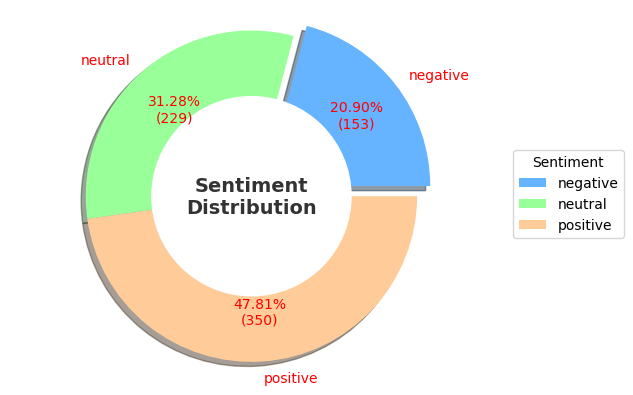

In [23]:
colors = ['#66b3ff', '#99ff99', '#ffcc99']

explode = (0.1, 0, 0)  

sentiment_counts = df1.groupby("Sentiment").size()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts, 
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  

plt.show()

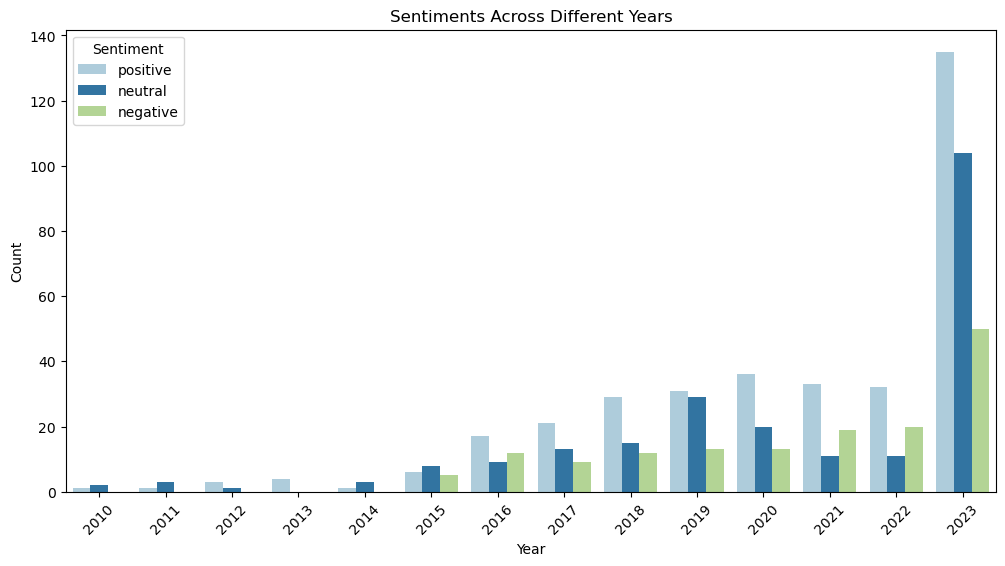

In [24]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='Sentiment', data=df1, palette='Paired')
plt.title('Sentiments Across Different Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [25]:
df

Text           Timestamp  \
0     Enjoying a beautiful day at the park!        ... 2023-01-15 12:30:00   
1     Traffic was terrible this morning.           ... 2023-01-15 08:45:00   
2     Just finished an amazing workout! 💪          ... 2023-01-15 15:45:00   
3     Excited about the upcoming weekend getaway!  ... 2023-01-15 18:20:00   
4     Trying out a new recipe for dinner tonight.  ... 2023-01-15 19:55:00   
..                                                 ...                 ...   
727  Collaborating on a science project that receiv... 2017-08-18 18:20:00   
728  Attending a surprise birthday party organized ... 2018-06-22 14:15:00   
729  Successfully fundraising for a school charity ... 2019-04-05 17:30:00   
730  Participating in a multicultural festival, cel... 2020-02-29 20:45:00   
731  Organizing a virtual talent show during challe... 2020-11-15 15:15:00   

                                      User   Platform  Retweets  Likes  \
0                            User123          Twitter      15.0   30.0   
1                            CommuterX        Twitter       5.0   10.0   
2                            FitnessFan     Instagram      20.0   40.0   
3                            AdventureX      Facebook       8.0   15.0   
4                            ChefCook       Instagram      12.0   25.0   
..                                     ...        ...       ...    ...   
727       ScienceProjectSuccessHighSchool    Facebook      20.0   39.0   
728            BirthdayPartyJoyHighSchool   Instagram      25.0   48.0   
729   CharityFundraisingTriumphHighSchool     Twitter      22.0   42.0   
730    MulticulturalFestivalJoyHighSchool    Facebook      21.0   43.0   
731    VirtualTalentShowSuccessHighSchool   Instagram      24.0   47.0   

       Country  Year     Month    Plaform Day_of_week  \
0          USA  2023   January    Twitter      Sunday   
1       Canada  2023   January    Twitter      Sunday   
2          USA  2023   January  Instagram      Sunday   
3           UK  2023   January   Facebook      Sunday   
4    Australia  2023   January  Instagram      Sunday   
..         ...   ...       ...        ...         ...   
727         UK  2017    August   Facebook      Friday   
728        USA  2018      June  Instagram      Friday   
729     Canada  2019     April    Twitter      Friday   
730         UK  2020  February   Facebook    Saturday   
731        USA  2020  November  Instagram      Sunday   

                                            Clean_Text  
0                                enjoy beauti day park  
1                                 traffic terribl morn  
2                                  finish amaz workout  
3                          excit upcom weekend getaway  
4                         tri new recip dinner tonight  
..                                                 ...  
727  collabor scienc project receiv recognit region...  
728  attend surpris birthday parti organ friend sur...  
729  success fundrais school chariti initi joy give...  
730  particip multicultur festiv celebr divers musi...  
731  organ virtual talent show challeng time bring ...  

[732 rows x 12 columns]

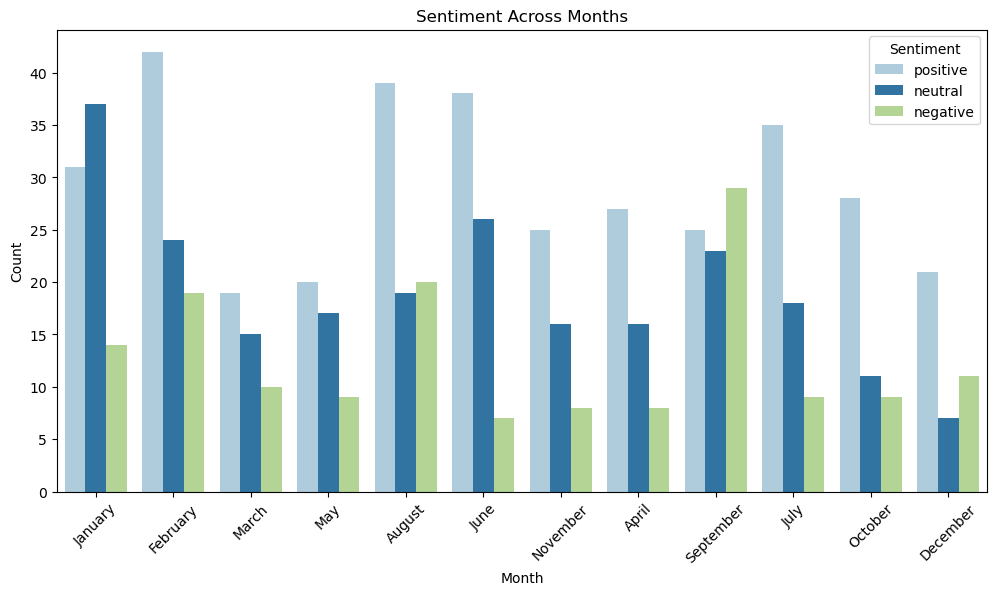

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Sentiment', data=df1, palette='Paired')
plt.title('Sentiment Across Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

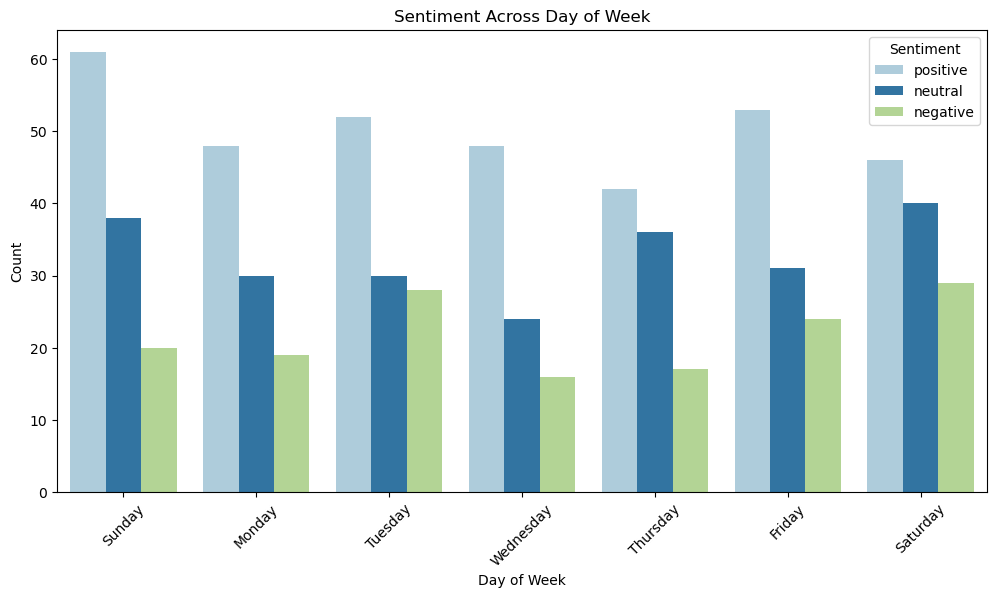

In [27]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Day_of_week', hue='Sentiment', data=df1, palette='Paired')
plt.title('Sentiment Across Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

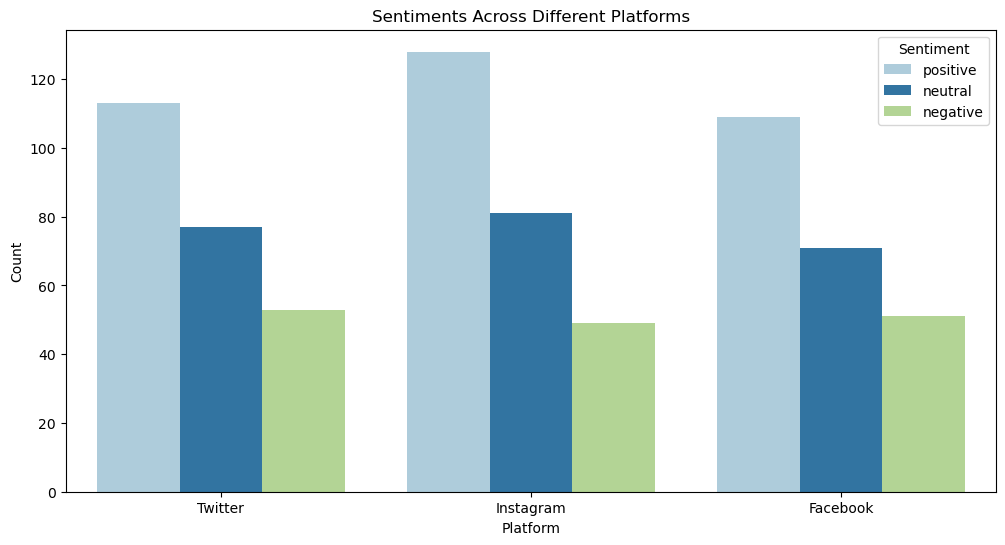

In [31]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Platform', hue='Sentiment', data=df1, palette='Paired')
plt.title('Sentiments Across Different Platforms')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [38]:
df1['Country'].value_counts().head(10).index

Index(['USA', 'UK', 'Canada', 'Australia', 'India', 'Brazil', 'France',
       'Japan', 'Germany', 'Italy'],
      dtype='object')

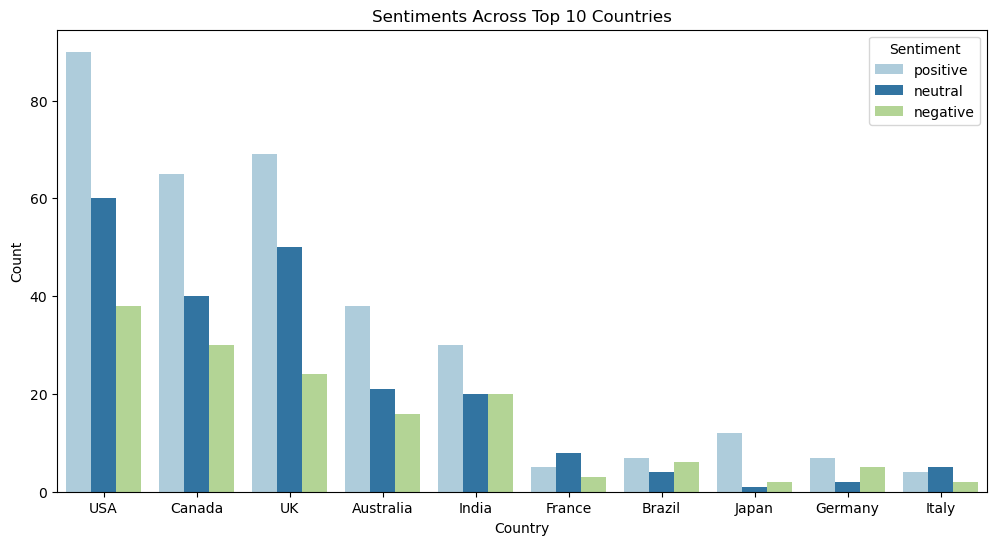

In [42]:
plt.figure(figsize=(12, 6))

top_countries = df1['Country'].value_counts().head(10).index
df_top_countries = df1[df1['Country'].isin(top_countries)]

sns.countplot(x='Country', hue='Sentiment', data=df_top_countries, palette='Paired')
plt.title('Sentiments Across Top 10 Countries')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [53]:
full_list_clean_text = df1['Clean_Text'].to_string(max_rows=None)
print(full_list_clean_text)

0                                  enjoy beauti day park
1                                   traffic terribl morn
2                                    finish amaz workout
3                            excit upcom weekend getaway
4                           tri new recip dinner tonight
5                            feel grate littl thing life
6                  raini day call cozi blanket hot cocoa
7                              new movi releas mustwatch
8                             polit discuss heat timelin
9                             miss summer vibe beach day
10                           publish new blog post check
11                                feel bit weather today
12                                explor citi hidden gem
13                                 new year new fit goal
14                              technolog chang way live
15                               reflect past look ahead
16                               adopt cute furri friend
17                         late

In [63]:
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())

top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(30), columns=['Common Words', 'Count'])

top_words_df.style.background_gradient(cmap='Paired')

In [71]:
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())

top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(30), columns=['Common Words', 'Count'])

fig = px.bar(top_words_df,
      x='Count',
      y='Common Words',
      title='Common Words in Text Data',
      orientation='h',
      width=700,
      height=700,
      color='Common Words')

fig.show()

In [72]:
df1

Text           Timestamp  \
0     Enjoying a beautiful day at the park!        ... 2023-01-15 12:30:00   
1     Traffic was terrible this morning.           ... 2023-01-15 08:45:00   
2     Just finished an amazing workout! 💪          ... 2023-01-15 15:45:00   
3     Excited about the upcoming weekend getaway!  ... 2023-01-15 18:20:00   
4     Trying out a new recipe for dinner tonight.  ... 2023-01-15 19:55:00   
..                                                 ...                 ...   
727  Collaborating on a science project that receiv... 2017-08-18 18:20:00   
728  Attending a surprise birthday party organized ... 2018-06-22 14:15:00   
729  Successfully fundraising for a school charity ... 2019-04-05 17:30:00   
730  Participating in a multicultural festival, cel... 2020-02-29 20:45:00   
731  Organizing a virtual talent show during challe... 2020-11-15 15:15:00   

                                      User   Platform  Retweets  Likes  \
0                            User123          Twitter      15.0   30.0   
1                            CommuterX        Twitter       5.0   10.0   
2                            FitnessFan     Instagram      20.0   40.0   
3                            AdventureX      Facebook       8.0   15.0   
4                            ChefCook       Instagram      12.0   25.0   
..                                     ...        ...       ...    ...   
727       ScienceProjectSuccessHighSchool    Facebook      20.0   39.0   
728            BirthdayPartyJoyHighSchool   Instagram      25.0   48.0   
729   CharityFundraisingTriumphHighSchool     Twitter      22.0   42.0   
730    MulticulturalFestivalJoyHighSchool    Facebook      21.0   43.0   
731    VirtualTalentShowSuccessHighSchool   Instagram      24.0   47.0   

       Country  Year     Month    Plaform Day_of_week  \
0          USA  2023   January    Twitter      Sunday   
1       Canada  2023   January    Twitter      Sunday   
2          USA  2023   January  Instagram      Sunday   
3           UK  2023   January   Facebook      Sunday   
4    Australia  2023   January  Instagram      Sunday   
..         ...   ...       ...        ...         ...   
727         UK  2017    August   Facebook      Friday   
728        USA  2018      June  Instagram      Friday   
729     Canada  2019     April    Twitter      Friday   
730         UK  2020  February   Facebook    Saturday   
731        USA  2020  November  Instagram      Sunday   

                                            Clean_Text  Vader_Score Sentiment  \
0                                enjoy beauti day park       0.4939  positive   
1                                 traffic terribl morn       0.0000   neutral   
2                                  finish amaz workout       0.0000   neutral   
3                          excit upcom weekend getaway       0.0000   neutral   
4                         tri new recip dinner tonight       0.0000   neutral   
..                                                 ...          ...       ...   
727  collabor scienc project receiv recognit region...       0.7845  positive   
728  attend surpris birthday parti organ friend sur...       0.9260  positive   
729  success fundrais school chariti initi joy give...       0.8176  positive   
730  particip multicultur festiv celebr divers musi...       0.0000   neutral   
731  organ virtual talent show challeng time bring ...       0.6486  positive   

                                             temp_list  
0                           [enjoy, beauti, day, park]  
1                             [traffic, terribl, morn]  
2                              [finish, amaz, workout]  
3                     [excit, upcom, weekend, getaway]  
4                   [tri, new, recip, dinner, tonight]  
..                                                 ...  
727  [collabor, scienc, project, receiv, recognit, ...  
728  [attend, surpris, birthday, parti, organ, frie...  
729  [success, fundrais, school, chariti, initi, jo..

In [75]:
Positive_Sent = df1[df1['Sentiment']=='positive']
Negative_Sent = df1[df1['Sentiment'] == 'negative']
Neutral_Sent = df1[df1['Sentiment'] == 'neutral']

In [84]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])

temp_positive_df = pd.DataFrame(top.most_common(30), columns = ['Common Words', 'Count'])
temp_positive_df.style.background_gradient(cmap='Greens')

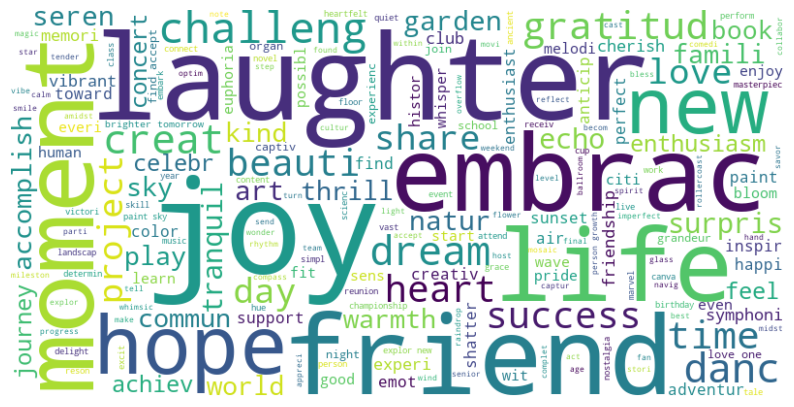

In [85]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [92]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])

temp_neutral_df = pd.DataFrame(top.most_common(30), columns=['Common Words', 'Count'])
temp_neutral_df.style.background_gradient(cmap='Blues')

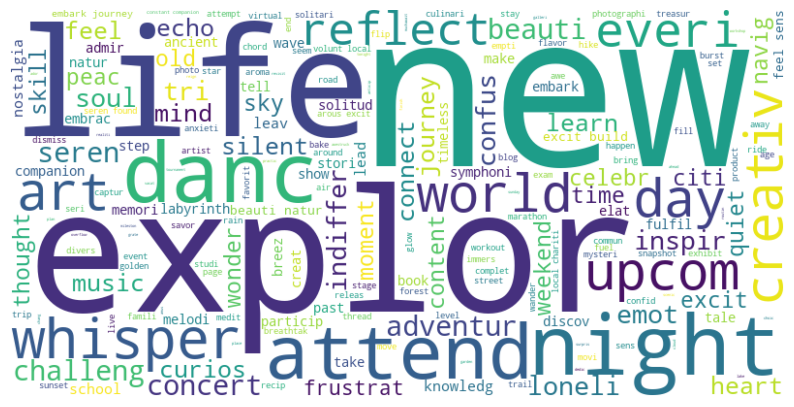

In [93]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [98]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])

top_negative_df = pd.DataFrame(top.most_common(30), columns=['Common Words', 'Count'])
top_negative_df.style.background_gradient(cmap='Reds')

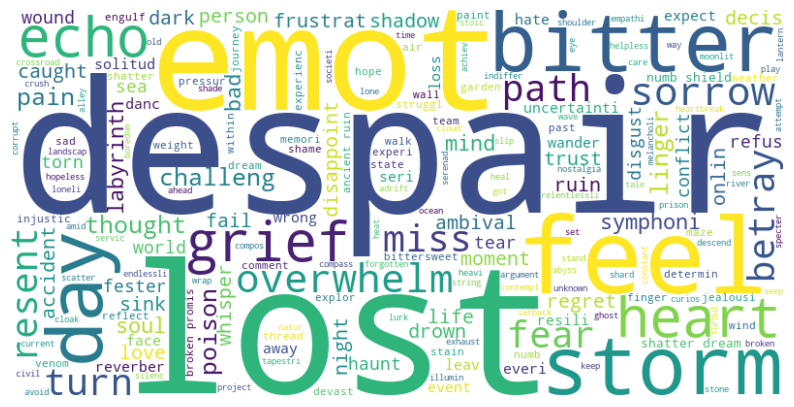

In [99]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Model Development

In [103]:
pip install --upgrade scikit-learn

     --------------------------------------- 11.0/11.0 MB 11.3 MB/s eta 0:00:00
     ------------------------------------- 301.8/301.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.1
    Uninstalling scikit-learn-1.2.1:
      Successfully uninstalled scikit-learn-1.2.1
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\tech3001\\AppData\\Local\\anaconda3\\Lib\\site-packages\\~klearn\\datasets\\_svmlight_format_fast.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [157]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier

In [124]:
df2 = df1.copy()

In [126]:
X = df2['Clean_Text'].values
y = df2['Sentiment'].values

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [168]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train_Tfidf = vectorizer.fit_transform(X_train)
X_test_Tfidf = vectorizer.transform(X_test)

In [169]:
pa_classifier = PassiveAggressiveClassifier(max_iter=50, random_state=42)
pa_classifier.fit(X_train_Tfidf, y_train)

PassiveAggressiveClassifier(max_iter=50, random_state=42)

In [170]:
y_pred = pa_classifier.predict(X_test_Tfidf)
accuracy_test = accuracy_score(y_test, y_pred)
classification_test = classification_report(y_test, y_pred)

In [173]:
print('Test Set Results')
print(f'Accuracy: {accuracy_test}')
print(f'Classification Report:\n {classification_test}')

Test Set Results
Accuracy: 0.7142857142857143
Classification Report:
               precision    recall  f1-score   support

    negative       0.79      0.81      0.80        32
     neutral       0.73      0.55      0.62        55
    positive       0.67      0.82      0.74        60

    accuracy                           0.71       147
   macro avg       0.73      0.72      0.72       147
weighted avg       0.72      0.71      0.71       147



In [145]:
logistic_classifier = LogisticRegression(max_iter=50, random_state=42)

logistic_classifier.fit(X_train_Tfidf, y_train)

LogisticRegression(max_iter=50, random_state=42)

In [160]:
y_pred = logistic_classifier.predict(X_test_Tfidf)

logistic_accuracy = accuracy_score(y_test, y_pred)
logistic_classification_test = classification_report(y_test, y_pred)

In [161]:
print('Logistic Regression Test Results')
print(f'Accuracy Test: {logistic_accuracy}')
print(f'Classification Report:\n {logistic_classification_test}')

Logistic Regression Test Results
Accuracy Test: 0.6326530612244898
Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.50      0.64        32
     neutral       0.80      0.36      0.50        55
    positive       0.55      0.95      0.70        60

    accuracy                           0.63       147
   macro avg       0.75      0.60      0.61       147
weighted avg       0.72      0.63      0.61       147



In [153]:
svm_classifier = SVC(random_state=42)

svm_classifier.fit(X_train_Tfidf, y_train)

SVC(random_state=42)

In [154]:
y_pred = svm_classifier.predict(X_test_Tfidf)

svm_accuracy = accuracy_score(y_test, y_pred)
svm_classification = classification_report(y_test, y_pred)

In [156]:
print('SVM Test Results')
print(f'SVM Accuracy: {svm_accuracy}')
print(f'SVM Classification Report: \n {svm_classification}')

SVM Test Results
SVM Accuracy: 0.5986394557823129
SVM Classification Report: 
               precision    recall  f1-score   support

    negative       1.00      0.38      0.55        32
     neutral       0.94      0.31      0.47        55
    positive       0.50      0.98      0.67        60

    accuracy                           0.60       147
   macro avg       0.82      0.56      0.56       147
weighted avg       0.78      0.60      0.57       147



In [175]:
param = {
    'loss':['hinge', 'squared_hinge'],
    'tol': [1e-3, 1e-4, 1e-5],
    'max_iter': [1000, 5000, 10000]
}

pac_classifier = PassiveAggressiveClassifier(random_state=42)

randomized_search = RandomizedSearchCV(pac_classifier, param_distributions=param, n_iter=10, cv=5, scoring='accuracy', random_state=42)
randomized_search.fit(X_train_Tfidf, y_train)

RandomizedSearchCV(cv=5, estimator=PassiveAggressiveClassifier(random_state=42),
                   param_distributions={'loss': ['hinge', 'squared_hinge'],
                                        'max_iter': [1000, 5000, 10000],
                                        'tol': [0.001, 0.0001, 1e-05]},
                   random_state=42, scoring='accuracy')

In [176]:
best_params = randomized_search.best_params_
best_params

{'tol': 0.0001, 'max_iter': 5000, 'loss': 'squared_hinge'}

In [177]:
best_pac_classifier = PassiveAggressiveClassifier(random_state=42, **best_params)

best_pac_classifier.fit(X_train_Tfidf, y_train)

PassiveAggressiveClassifier(loss='squared_hinge', max_iter=5000,
                            random_state=42, tol=0.0001)

In [179]:
y_pred_best_pac_classifier = best_pac_classifier.predict(X_test_Tfidf)

y_pred_best_pac_classifier

array(['neutral', 'neutral', 'negative', 'negative', 'positive',
       'negative', 'neutral', 'positive', 'positive', 'positive',
       'negative', 'neutral', 'negative', 'negative', 'positive',
       'positive', 'neutral', 'positive', 'negative', 'neutral',
       'neutral', 'positive', 'negative', 'positive', 'neutral',
       'neutral', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'neutral',
       'positive', 'positive', 'neutral', 'negative', 'neutral',
       'positive', 'positive', 'positive', 'positive', 'neutral',
       'positive', 'neutral', 'neutral', 'neutral', 'positive',
       'positive', 'neutral', 'negative', 'positive', 'neutral',
       'neutral', 'positive', 'positive', 'positive', 'negative',
       'negative', 'neutral', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'negative', 'positive', 'neutral', 'neutral', 'positive',
       'positive'

In [180]:
conf_matrix_test = confusion_matrix(y_test, y_pred_best_pac_classifier)
accuracy_test_pac = accuracy_score(y_test, y_pred_best_pac_classifier)
classification_report_pac = classification_report(y_test, y_pred_best_pac_classifier)

In [184]:
print('Best Parameters of PAC')
print(f'Best Hyperparameters: {best_params}')
print(f'Accuracy Score of PAC: {accuracy_test_pac}')
print(f'Classification Report of PAC:\n {classification_report_pac}')
print(f'Confusion Matrix of PAC:\n {conf_matrix_test}')

Best Parameters of PAC
Best Hyperparameters: {'tol': 0.0001, 'max_iter': 5000, 'loss': 'squared_hinge'}
Accuracy Score of PAC: 0.7210884353741497
Classification Report of PAC:
               precision    recall  f1-score   support

    negative       0.81      0.81      0.81        32
     neutral       0.73      0.55      0.62        55
    positive       0.68      0.83      0.75        60

    accuracy                           0.72       147
   macro avg       0.74      0.73      0.73       147
weighted avg       0.73      0.72      0.72       147

Confusion Matrix of PAC:
 [[26  1  5]
 [ 6 30 19]
 [ 0 10 50]]


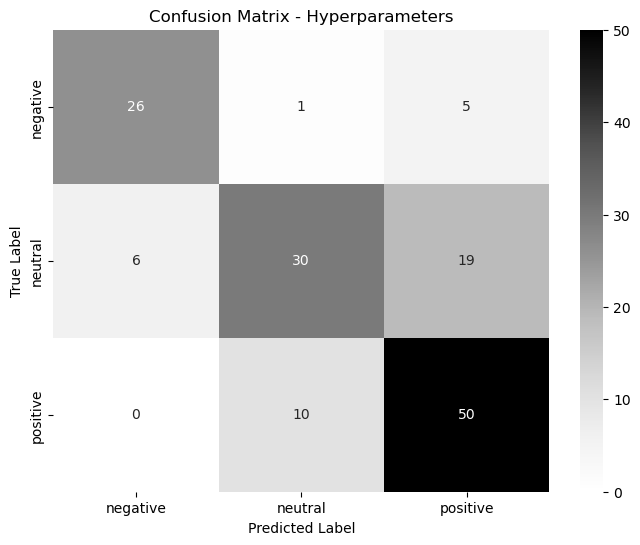

In [185]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greys', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix - Hyperparameters')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()